In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle, os

2024-02-12 07:25:18.485023: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model_name = 'enformer'

bin_index = [447, 448]
track_index = [4824, 5110, 5111]
target_df = pd.read_csv(f'../data/enformer_targets_human.txt', sep='\t')
cell_lines = [utils.clean_cell_name(target_df.iloc[t]['description']) for t in track_index]
pdf_base_dir = utils.make_dir('pdfs')
pdf_dir = utils.make_dir(f'{pdf_base_dir}/context_swap/')

In [3]:
result_summary = {}
res_dir = '../results/context_swap_test/enformer'
for cell_index, cell_line in enumerate(cell_lines):
    result_files = glob.glob(f'../results/context_swap_test/enformer/{cell_line}/*')
    df_context = pd.read_csv(f'../results/summary_csvs/{model_name}/{cell_line}_selected_contexts.csv')
    df_context['source_id'] = [p.split('/')[-1].split('.')[0] for p in df_context['path']]
    context_id = dict(zip(df_context['source_id'], df_context['context']))
    preds = []
    for i, row_src in tqdm(df_context.iterrows()):
        res = utils.read_pickle(f'{res_dir}/{cell_line}/src_{row_src["source_id"]}_dest_{row_src["source_id"]}.pickle')

        src_wt = res[0, bin_index, cell_index].mean()
        for j, row_dest in df_context.iterrows():
            res = utils.read_pickle(f'../results/context_swap_test/enformer/{cell_line}/src_{row_src["source_id"]}_dest_{row_dest["source_id"]}.pickle')
            preds.append([row_src["source_id"], row_src['context'], 
                          row_dest["source_id"], row_dest['context'],
                          res[0, bin_index, cell_index].mean()/src_wt])
    df = pd.DataFrame(preds)
    df.columns = ['source', 'source_context', 'target', 'target_context', 'normalised']
    result_summary[cell_line] = df

400it [00:35, 11.39it/s]
461it [00:46,  9.94it/s]
600it [01:19,  7.58it/s]


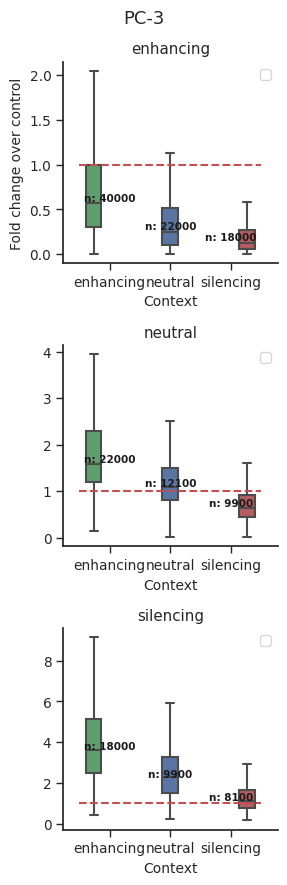

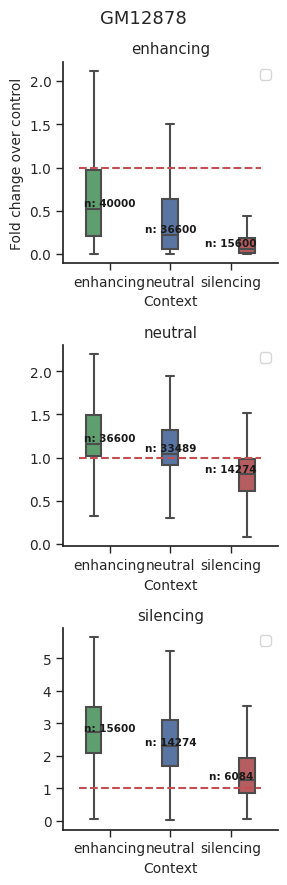

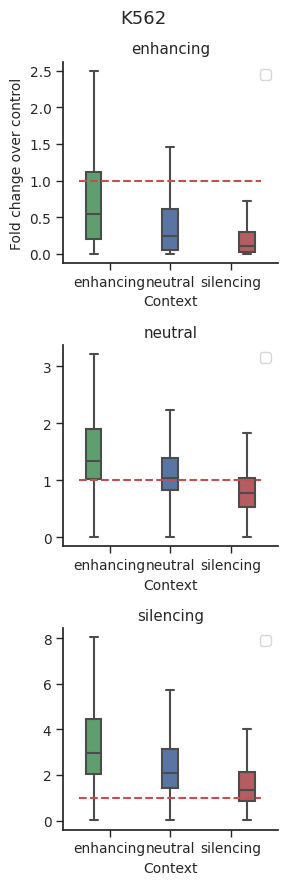

In [12]:
for cell_line, dfs in result_summary.items():    
    ylims = [2, 1.5, 7.5]
    sns.set(font_scale = .9)
    sns.set_style(style='white')
    plt.rcParams['xtick.major.size'] = 5
    plt.rcParams['xtick.major.width'] = 1
    
    plt.rcParams['ytick.major.size'] = 5
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
    
    my_pal = {"enhancing": "g", "neutral": "b", "silencing":"r"}
    
    fig, axes = plt.subplots(3, 1, sharey=False, figsize=[3, 9]) 
    
    for i, (source_context, dfs_by_content) in enumerate(dfs.groupby('source_context')):
        ax= axes[i]
        sns.boxplot(x='target_context', y='normalised', data=dfs_by_content, 
                    hue='target_context', showfliers=False, palette=my_pal, ax=ax)
        ax.set_title(source_context)
        x1, x2 = ax.get_xlim()
        # ax.set_ylim(0, ylims[i])
        ax.legend('')
        ax.hlines(1, x1, x2, color='r', linestyles='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('Context', fontsize=10)
        if i == 0:
            ax.set_ylabel('Fold change over control', fontsize=10)
        else:
            ax.set_ylabel('')
        # add number of observations in each box
        if cell_line !='K562':
            medians = dfs_by_content.groupby(['target_context'])['normalised'].median().values
            nobs = dfs_by_content['target_context'].value_counts().values
            nobs = [str(x) for x in nobs.tolist()]
            nobs = ["n: " + i for i in nobs]
    
            # Add it to the plot
            pos = range(len(nobs))
            for tick,label in zip(pos,ax.get_xticklabels()):
                ax.text(pos[tick],
                        medians[tick] + 0.03,
                        nobs[tick],
                        horizontalalignment='center',
                        size='x-small',
                        color='k',
                        weight='semibold')
        
    plt.suptitle(cell_line)
    plt.tight_layout()
    fig.savefig(f'{pdf_dir}/{model_name}_{cell_line}_context_swap_boxplots.pdf', format='pdf', dpi=300, bbox_inches='tight')
